# Optimizing Python Code with [Cython](https://cython.org/)

In [1]:
import Cython
from random import random
import math
import numpy as np
import matplotlib.pyplot as plt

# This is needed to load the Cython magic
%load_ext Cython

## Calculating $\pi$ using Monte Carlo Integration

### Pure Python

In [2]:
def pi_mc(n=1000):
    '''Calculate PI using Monte Carlo method'''
    in_circle = 0
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [3]:
%time pi_mc(10000000)

CPU times: user 5.88 s, sys: 0 ns, total: 5.88 s
Wall time: 6.28 s


3.1415424

### Cython

#### 1. Use `cython` cell magic without making any code change

In [4]:
%%cython

from random import random

def pi_mc(n=1000):
    '''Calculate PI using Monte Carlo method'''
    in_circle = 0
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [5]:
%time pi_mc(10000000)

CPU times: user 3.91 s, sys: 12.4 ms, total: 3.92 s
Wall time: 4.39 s


3.14173

#### 2. Static type declarations in Cython with `cdef`

Static type declarations allow Cython to step out of the dynamic nature of the Python code and produce efficient **C** code.

In [6]:
%%cython

from random import random

def pi_mc(n=1000):
    '''Calculate PI using Monte Carlo method'''
    cdef int in_circle = 0
    cdef int i
    cdef double x, y
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [7]:
%time pi_mc(10000000)

CPU times: user 859 ms, sys: 3.55 ms, total: 863 ms
Wall time: 982 ms


3.1414884

#### 3. Using Cython `annotate` option and inspect the generated C code

In [8]:
%%cython --annotate

from random import random

def pi_mc(int n=1000):
    '''Calculate PI using Monte Carlo method'''
    cdef:
        int in_circle = 0
        int i
        double x, y
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [9]:
%time pi_mc(10000000)

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.08 s


3.141506

## Types of Cython functions

Cython offers three different types of function declared with `def`, `cdef`, `cpdef`:

1. Functions declared with `def` can be called from Python and Cython code.
2. Functions declared with `cdef` can be only called from Cython code.
3. `cpdef` causes Cython to create two versions of the function. One which is used when the function is called from Cython code and one when it is called from Python.

In [10]:
%%cython 


cdef double cube(double x):
    return x * x * x


cpdef double cube_sum(double x, double y):
    return cube(x) + cube(y)

### Function Inlining

We can use the `cdef inline` for small functions that are used often and Cython inlines them reducing overhead

In [11]:
%%cython --annotate


cdef inline double cube(double x):
    return x * x * x


cpdef double cube_sum(double x, double y):
    return cube(x) + cube(y)

## Typed Memory Views

Cython allows access to the contents of NumPy arrays by **memory views**.

In [12]:
%%cython --annotate

def my_sum(double[:] x):
    cdef int i, nx = x.shape[0]
    cdef double s = 0.0
    for i in range(nx):
        s += x[i]
        
    return s

In [13]:
x = np.ones(1000, dtype=np.float64)
s1 = my_sum(x)
s2 = x.sum()
print(s1, s2)

1000.0 1000.0


In [14]:
%%cython --annotate

def my_sum2d(double[:, :] x):
    cdef int i, j, nx = x.shape[0], ny = x.shape[1]
    cdef double s = 0.0
    for i in range(nx):
        for j in range(ny):
            s += x[i, j]
        
    return s

In [15]:
x = np.ones((1000, 1000), dtype=np.float64)
s1 = my_sum2d(x)
s2 = x.sum()
print(s1, s2)

1000000.0 1000000.0


## Disable bounds checking and wraparound

For safety reasons, Cython checks if we try to access elements out of the array boundaries. 
Furthermore it allows using negative array indices. We can exhange safety with performance disabling both of them.


In [16]:
%%cython --annotate

from cython cimport wraparound, boundscheck

@wraparound(False)
@boundscheck(False)
cpdef double my_sum2d(double[:, :] x):
    cdef int i, j, nx = x.shape[0], ny = x.shape[1]
    cdef double s = 0.0
    for i in range(nx):
        for j in range(ny):
            s += x[i, j]
        
    return s

## Releasing the GIL and parallelizing loops

### Calculating Julia Sets

In [17]:
%%cython

from cython cimport boundscheck, wraparound

@wraparound(False)
@boundscheck(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    nx = X.shape[0]
    ny = Y.shape[1]
    for i in range(nx):
        for j in range(ny):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

775 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


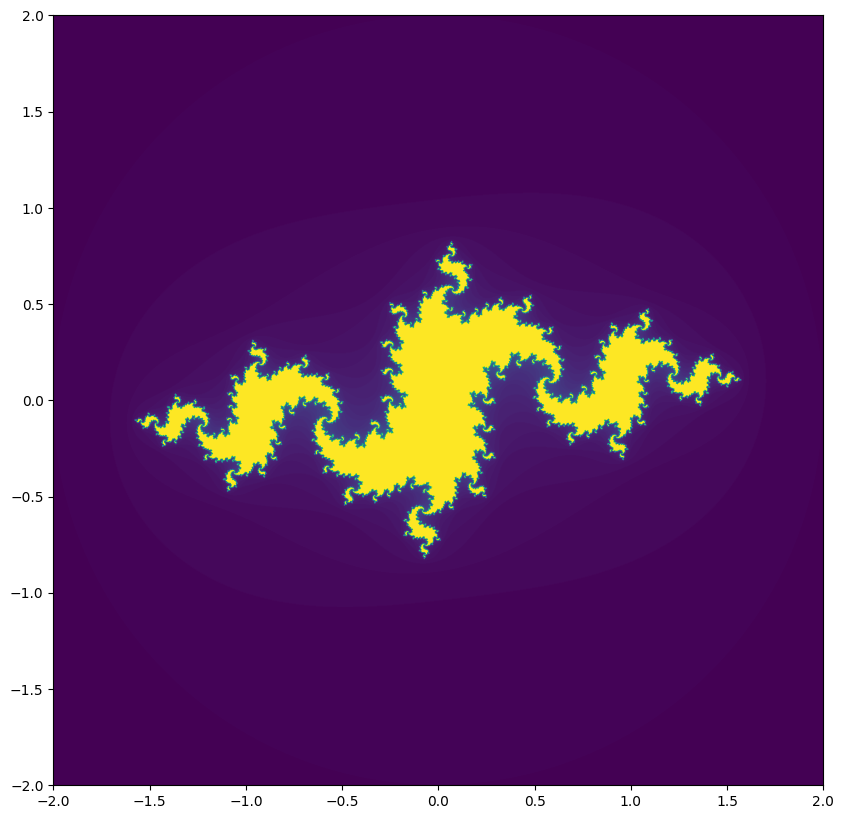

In [18]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

In [19]:
%%cython

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    nx = X.shape[0]
    ny = Y.shape[1]
    for i in prange(nx, nogil=True):
        for j in range(ny):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

769 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


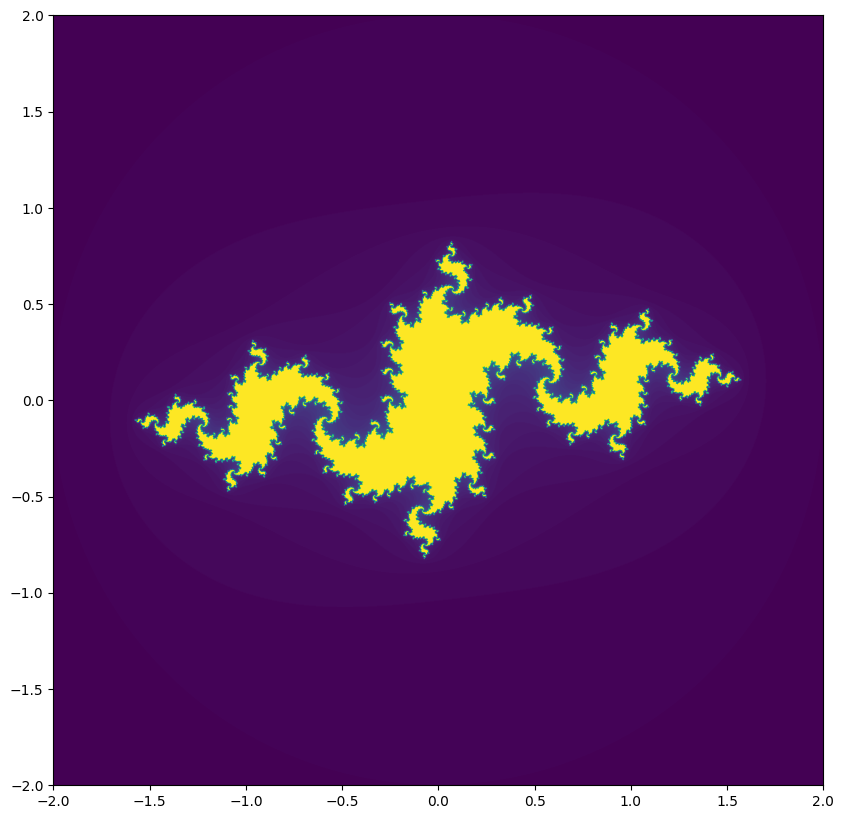

In [20]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

In [21]:
%%cython

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    nx = X.shape[0]
    ny = Y.shape[1]
    for i in prange(nx, nogil=True):
        for j in range(ny):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

770 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


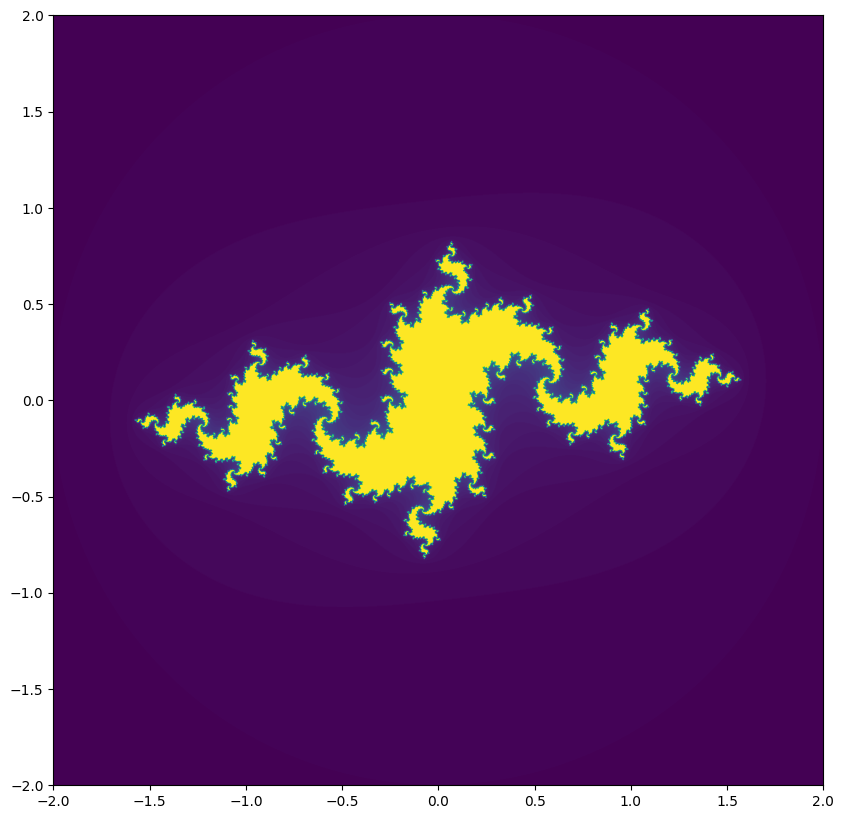

In [22]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

### !!! WE FORGOT TO PUT THE CORRECT COMPILATION/LINKING OPTIONS !!!

In [23]:
%%cython

# distutils: extra_compile_args = -fopenmp -march=native
# distutils: extra_link_args = -fopenmp
from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    nx = X.shape[0]
    ny = Y.shape[1]
    for i in prange(nx, nogil=True):
        for j in range(ny):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

352 ms ± 638 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


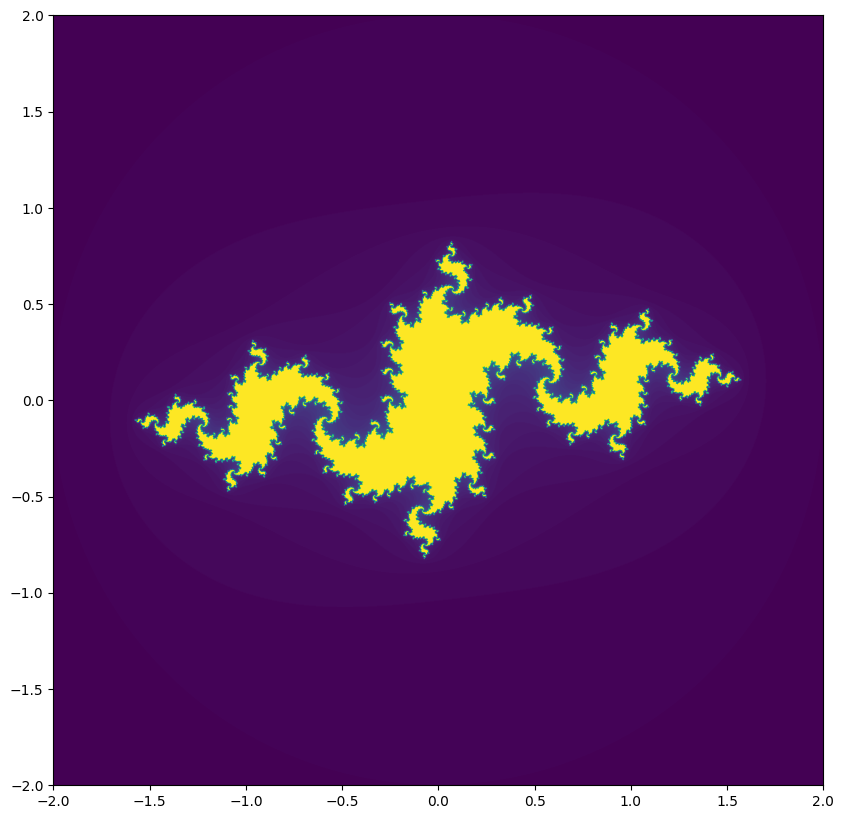

In [24]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

# Additional Cython Features

## Automatic Type Inference Using Cython's `infer_types`

In [25]:
import numpy as np
from random import random
import Cython

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [26]:
%%cython -a

from random import random
from cython cimport infer_types

cdef inline double my_rand():
    return random()

@infer_types(True)
cpdef pi_mc_inferred(n=1000):
    '''Calculate PI using Monte Carlo method'''
    in_circle = 0
    for i in range(n):
        x = my_rand()
        y = my_rand()
        if x * x + y * y <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [27]:
%time pi_mc_inferred(10000000)

CPU times: user 861 ms, sys: 3.78 ms, total: 865 ms
Wall time: 863 ms


3.1419888

## Cython Extensions Types

In [28]:
class PyRectangle:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def area(self):
        return self.x * self.y
    
    def perimeter(self):
        return 2.0 * (self.x + self.y)

In [29]:
%%cython 

cdef class CyRectangle:
    cdef:
        double x, y
        
    def __cinit__(self, x, y):
        self.x = x
        self.y = y
        
    cpdef double area(self):
        return self.x * self.y
    
    cpdef double perimeter(self):
        return 2.0 * (self.x + self.y)

In [30]:
a = CyRectangle(1, 2)
print(a.area(), a.perimeter())

2.0 6.0


In [31]:
%%cython
from random import random

cdef class CyRectangle:
    cdef:
        double x, y
        
    def __cinit__(self, x, y):
        self.x = x
        self.y = y
        
    cpdef double area(self):
        return self.x * self.y
    
    cpdef double perimeter(self):
        return 2.0 * (self.x + self.y)
    
cdef class CyRectangles:
    cdef:
        list rectangles
        
    def __cinit__(self, int n):
        cdef unsigned int i
        self.rectangles = []
        for i in range(n):
            self.rectangles.append(CyRectangle(random(), random()))
            
    cpdef double total_area(self):
        cdef CyRectangle rect
        cdef double area = 0.0
        for rect in self.rectangles:
            area += rect.area()
            
        return area

/home/4/23M30260/.cache/ipython/cython/_cython_magic_c3923323792a4222d075eace97e996fc.c: In function ‘__pyx_pf_46_cython_magic_c3923323792a4222d075eace97e996fc_12CyRectangles___cinit__’:
/home/4/23M30260/.cache/ipython/cython/_cython_magic_c3923323792a4222d075eace97e996fc.c:2085:33: warning: comparison of integer expressions of different signedness: ‘unsigned int’ and ‘int’ [-Wsign-compare]
   for (__pyx_t_4 = 0; __pyx_t_4 < __pyx_t_3; __pyx_t_4+=1) {
                                 ^


In [32]:
a = CyRectangles(100000)

In [33]:
a.total_area()

25015.92544965973

## C-like Allocation/Dealllocation

In [34]:
%%cython

from libc.stdlib cimport malloc, free


cdef class CyRangeVector:
    cdef:
        int *data
        int size
        
    def __cinit__(self, int start, int end):
        cdef unsigned int i
        if start >= end:
            raise Exception(f'{start} >= {end}')
        self.size = end - start
        self.data = <int*>malloc(self.size * sizeof(int))
        
        for i in range(start, end):
            self.data[i - start] = i
            
    def __getitem__(self, int i):
        if i >= self.size or i < 0:
            return -1

        return self.data[i]
    
    def __dealloc__(self):
        free(self.data)

/home/4/23M30260/.cache/ipython/cython/_cython_magic_4c5a3816d6ccf4bb04ad7453e78b3c97.c: In function ‘__pyx_pf_46_cython_magic_4c5a3816d6ccf4bb04ad7453e78b3c97_13CyRangeVector___cinit__’:
/home/4/23M30260/.cache/ipython/cython/_cython_magic_4c5a3816d6ccf4bb04ad7453e78b3c97.c:1536:45: warning: comparison of integer expressions of different signedness: ‘unsigned int’ and ‘int’ [-Wsign-compare]
   for (__pyx_t_8 = __pyx_v_start; __pyx_t_8 < __pyx_t_7; __pyx_t_8+=1) {
                                             ^


In [35]:
my_range = CyRangeVector(10, 11000)
my_range[2]

12

## Interacting with the C++ Standard Template Library

As long as we start using the C++ STL from inside Cython we have to switch to `language=c++`

In [36]:
%%cython

# distutils: language=c++

from libcpp.vector cimport vector

cdef class CyRangeVector:
    cdef:
        vector[int] data
        
    def __cinit__(self, int start, int end):
        cdef unsigned int i
        if start >= end:
            raise Exception(f'{start} >= {end}')
        for i in range(start, end):
            self.data.push_back(i)
            
    def __getitem__(self, int i):
        if i >= self.data.size() or i < 0:
            return None
        
        return self.data[i]

/home/4/23M30260/.cache/ipython/cython/_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a.cpp: In function ‘int __pyx_pf_46_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a_13CyRangeVector___cinit__(__pyx_obj_46_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a_CyRangeVector*, int, int)’:
/home/4/23M30260/.cache/ipython/cython/_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a.cpp:1575:45: warning: comparison of integer expressions of different signedness: ‘unsigned int’ and ‘int’ [-Wsign-compare]
   for (__pyx_t_8 = __pyx_v_start; __pyx_t_8 < __pyx_t_7; __pyx_t_8+=1) {
                                   ~~~~~~~~~~^~~~~~~~~~~
/home/4/23M30260/.cache/ipython/cython/_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a.cpp: In function ‘PyObject* __pyx_pf_46_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a_13CyRangeVector_2__getitem__(__pyx_obj_46_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a_CyRangeVector*, int)’:
/home/4/23M30260/.cache/ipython/cython/_cython_magic_9239fe6a4f0d37a8cc985b11ecec0d2a.cpp:1666:27:

In [37]:
v = CyRangeVector(1, 20)
print(v[1])

2


In [38]:
%%cython

# distutils: language=c++

from libcpp.vector cimport vector

cpdef vector[int] cy_range(int start, int end):
    cdef vector[int] v
    cdef unsigned int i
    for i in range(start, end):
        v.push_back(i)
    
    return v

/home/4/23M30260/.cache/ipython/cython/_cython_magic_0c85301c471a988ef378b7e7fb36b365.cpp: In function ‘std::vector<int> __pyx_f_46_cython_magic_0c85301c471a988ef378b7e7fb36b365_cy_range(int, int, int)’:
/home/4/23M30260/.cache/ipython/cython/_cython_magic_0c85301c471a988ef378b7e7fb36b365.cpp:1336:45: warning: comparison of integer expressions of different signedness: ‘unsigned int’ and ‘int’ [-Wsign-compare]
   for (__pyx_t_3 = __pyx_v_start; __pyx_t_3 < __pyx_t_2; __pyx_t_3+=1) {
                                   ~~~~~~~~~~^~~~~~~~~~~


In [39]:
x = cy_range(1, 10)
print(x, type(x))

[1, 2, 3, 4, 5, 6, 7, 8, 9] <class 'list'>


### Additional STL libraries are available and you can look at their [declaration files](https://github.com/cython/cython/tree/master/Cython/Includes/libcpp)